## Introduction

This notebook will guide you through the basic steps to get started with Active Vision.

By the end of this notebook, you will be able to:

- Understand the basic workflow of active learning
- Understand the basic components of Active Vision
- Understand how to use Active Vision to train a model
- Understand how to use Active Vision to iteratively improve your dataset

Before we start, we need to prepare 3 sets of data:

- Initial samples: A dataset of labeled images to train an initial model. If you don't have any labeled data, you can label some images yourself.
- Unlabeled samples: A dataset of unlabeled images. We will continuously sample from this set using active learning strategies.
- Evaluation samples: A dataset of labeled images. We will use this set to evaluate the performance of the model. This is the test set, DO NOT use it for active learning. Split this out in the beginning.

We will use the Imagenette dataset as a working example in this notebook.


## Load the dataset

`active-vision` currently supports datasets in a pandas dataframe format. The dataframe should have at least 2 columns: `filepath` and `label`.

In [1]:
import pandas as pd

initial_samples = pd.read_parquet("imagenette/initial_samples.parquet")
initial_samples.head()

,filepath,label
0,data/imagenette/2/00710.jpg,cassette player
1,data/imagenette/2/00063.jpg,cassette player
2,data/imagenette/2/00506.jpg,cassette player
3,data/imagenette/2/00575.jpg,cassette player
4,data/imagenette/2/00136.jpg,cassette player


Let's check the distribution of the labels.

In [2]:
initial_samples["label"].value_counts()


label
cassette player     10
tench               10
chain saw           10
church              10
parachute           10
gas pump            10
English springer    10
golf ball           10
garbage truck       10
French horn         10
Name: count, dtype: int64

## Create an ActiveLearner

Now that we have an initial dataset, we can load it into an `ActiveLearner` object with a model.

Any fastai and timm models are supported. For simplicity, we will use a `resnet18` model.

In [3]:
from active_vision import ActiveLearner
from fastai.vision.models.all import resnet18

al = ActiveLearner(resnet18)

2025-01-25 00:01:47.070 | INFO     | active_vision.core:load_model:41 - Loading fastai model resnet18


We can load the initial samples into the `ActiveLearner` object.

In [4]:
al.load_dataset(initial_samples, 
                filepath_col="filepath", 
                label_col="label", 
                batch_size=8)

2025-01-25 00:01:47.075 | INFO     | active_vision.core:load_dataset:59 - Loading dataset from filepath and label
2025-01-25 00:01:47.075 | INFO     | active_vision.core:load_dataset:61 - Creating dataloaders
2025-01-25 00:01:47.321 | INFO     | active_vision.core:load_dataset:83 - Creating learner
2025-01-25 00:01:47.473 | INFO     | active_vision.core:load_dataset:92 - Done. Ready to train.


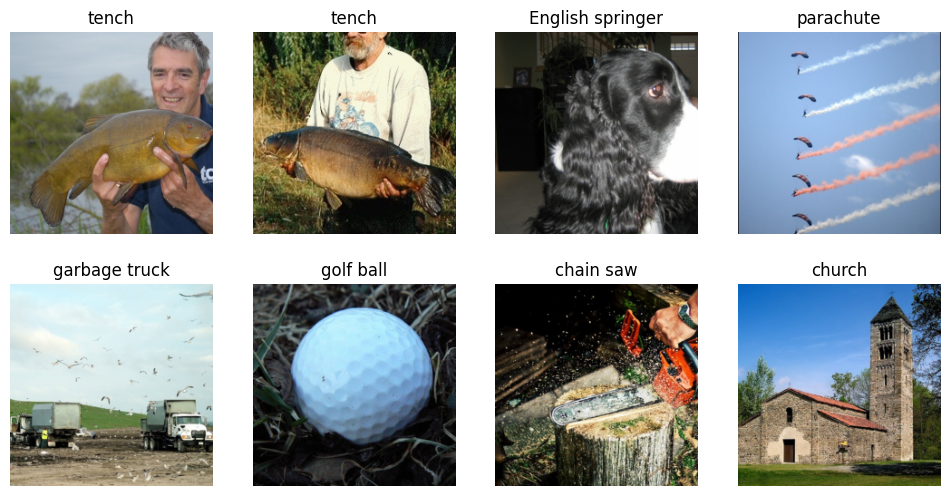

In [5]:
al.show_batch()

You can inspect the train and validation sets too.

In [14]:
al.train_set

,filepath,label
51,data/imagenette/7/05378.jpg,gas pump
83,data/imagenette/6/07797.jpg,garbage truck
97,data/imagenette/5/08999.jpg,French horn
75,data/imagenette/8/06618.jpg,golf ball
9,data/imagenette/2/00420.jpg,cassette player
...,...,...
28,data/imagenette/3/02542.jpg,chain saw
5,data/imagenette/2/00176.jpg,cassette player
29,data/imagenette/3/02582.jpg,chain saw
60,data/imagenette/1/06189.jpg,English springer


In [15]:
al.valid_set

,filepath,label
4,data/imagenette/2/00136.jpg,cassette player
64,data/imagenette/1/06574.jpg,English springer
40,data/imagenette/9/04652.jpg,parachute
54,data/imagenette/7/05488.jpg,gas pump
20,data/imagenette/3/02629.jpg,chain saw
31,data/imagenette/4/03479.jpg,church
82,data/imagenette/6/08366.jpg,garbage truck
57,data/imagenette/7/05299.jpg,gas pump
33,data/imagenette/4/03555.jpg,church
37,data/imagenette/4/02843.jpg,church


## Train 

Now that we have the initial dataset, we can train the model.

But first, let's check the optimal learning rate for the model.

2025-01-25 00:01:48.042 | INFO     | active_vision.core:lr_find:115 - Finding optimal learning rate


2025-01-25 00:01:54.456 | INFO     | active_vision.core:lr_find:117 - Optimal learning rate: 0.00363078061491251


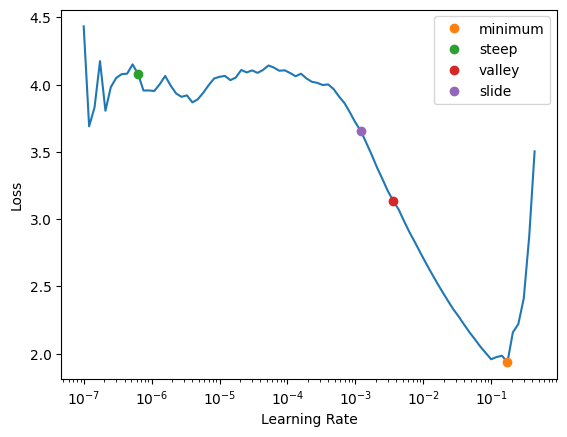

In [8]:
al.lr_find()

Not let's use the optimal learning rate to train the model end-to-end for 3 epochs and 1 epoch of head tuning.

2025-01-25 00:01:54.717 | INFO     | active_vision.core:train:128 - Training head for 1 epochs
2025-01-25 00:01:54.718 | INFO     | active_vision.core:train:129 - Training model end-to-end for 3 epochs
2025-01-25 00:01:54.718 | INFO     | active_vision.core:train:130 - Learning rate: 0.005 with one-cycle learning rate scheduler


epoch,train_loss,valid_loss,accuracy,time
0,2.871501,0.771290,0.750000,00:01


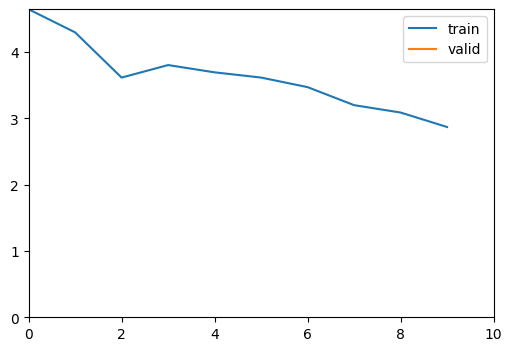

epoch,train_loss,valid_loss,accuracy,time
0,0.460057,0.409270,0.850000,00:01
1,0.370149,0.635701,0.800000,00:01
2,0.286742,0.720829,0.800000,00:01


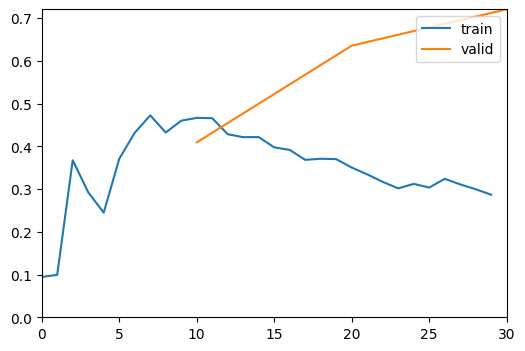

In [9]:
al.train(epochs=3, lr=5e-3, head_tuning_epochs=1)

## Evaluate

Now that we have a trained model, we can evaluate it on the evaluation set.

In [12]:
evaluation_df = pd.read_parquet("imagenette/evaluation_samples.parquet")
evaluation_df

,filepath,label
0,data/imagenette/2/00000.jpg,cassette player
1,data/imagenette/2/00001.jpg,cassette player
2,data/imagenette/2/00002.jpg,cassette player
3,data/imagenette/2/00003.jpg,cassette player
4,data/imagenette/2/00004.jpg,cassette player
...,...,...
3920,data/imagenette/5/03920.jpg,French horn
3921,data/imagenette/5/03921.jpg,French horn
3922,data/imagenette/5/03922.jpg,French horn
3923,data/imagenette/5/03923.jpg,French horn


In [11]:
al.evaluate(evaluation_df, filepath_col="filepath", label_col="label")

2025-01-25 00:02:04.166 | INFO     | active_vision.core:evaluate:183 - Accuracy: 89.22%


0.8922292993630573

That is a good start. 89% accuracy is not bad for a first try with only 80 labeled samples. Let's see if we can improve it.

## Predict

Using the model, we can predict the labels of the unlabeled samples and get the most impactful samples to label.


In [16]:
df = pd.read_parquet("imagenette/unlabeled_samples.parquet")
filepaths = df["filepath"].tolist()
len(filepaths)

9369

In [17]:
pred_df = al.predict(filepaths, batch_size=128)
pred_df

2025-01-25 00:12:36.925 | INFO     | active_vision.core:predict:139 - Running inference on 9369 samples


,filepath,pred_label,pred_conf,probs,logits
0,data/imagenette/2/00000.jpg,cassette player,0.999940,"[3.8786602090112865e-06, 2.0944246443832526e-06, 0.9999401569366455, 5.659975158778252e-06, 1.2189193654421615e-08, 3.137968860755791e-06, 5.577669526246609e-06, 1.6730854213165003e-06, 3.2309548259945586e-05, 5.561352736549452e-06]","[-1.6552734375, -2.271484375, 10.8046875, -1.27734375, -7.41796875, -1.8671875, -1.2919921875, -2.49609375, 0.464599609375, -1.294921875]"
1,data/imagenette/2/00001.jpg,cassette player,0.996448,"[4.007924144389108e-05, 0.0001770971284713596, 0.9964480400085449, 4.143233672948554e-05, 6.213659071363509e-05, 0.00016007207159418613, 0.0026889692526310682, 3.355292938067578e-05, 0.00015110982349142432, 0.00019756612891796976]","[-2.38671875, -0.90087890625, 7.734375, -2.353515625, -1.9482421875, -1.001953125, 1.8193359375, -2.564453125, -1.0595703125, -0.79150390625]"
2,data/imagenette/2/00002.jpg,cassette player,0.999960,"[4.068855105288094e-06, 2.1588432446151273e-06, 0.9999604225158691, 9.62526272019204e-08, 2.7002775823348202e-05, 1.9579856598284096e-06, 3.7465749755938305e-06, 2.970585910588852e-07, 2.372987779608593e-07, 1.4878810361551587e-07]","[-0.638671875, -1.2724609375, 11.7734375, -4.3828125, 1.25390625, -1.3701171875, -0.72119140625, -3.255859375, -3.48046875, -3.947265625]"
3,data/imagenette/2/00004.jpg,cassette player,0.979522,"[0.007508011534810066, 3.5657776606967673e-06, 0.9795216917991638, 0.0006528471712954342, 9.259342186851427e-05, 0.0010664233705028892, 0.010988288559019566, 6.754462083335966e-05, 9.027201303979382e-05, 8.72256623551948e-06]","[2.6328125, -5.01953125, 7.50390625, 0.1904296875, -1.7626953125, 0.68115234375, 3.013671875, -2.078125, -1.7880859375, -4.125]"
4,data/imagenette/2/00005.jpg,cassette player,0.797918,"[0.011532734148204327, 0.003183037508279085, 0.7979180216789246, 0.009069844149053097, 0.0023915632627904415, 0.00016750465147197247, 0.1725618839263916, 0.0006079384475015104, 0.0024530640803277493, 0.00011445157724665478]","[0.87646484375, -0.410888671875, 5.11328125, 0.63623046875, -0.69677734375, -3.35546875, 3.58203125, -2.06640625, -0.67138671875, -3.736328125]"
...,...,...,...,...,...
9364,data/imagenette/5/09464.jpg,French horn,0.987643,"[0.00029267228092066944, 0.9876433610916138, 0.001452236552722752, 4.644334330805577e-05, 0.005708757322281599, 0.002765971701592207, 0.0017633169190958142, 5.4510288464371115e-05, 6.473256507888436e-05, 0.0002079414698528126]","[-1.2373046875, 6.88671875, 0.364501953125, -3.078125, 1.7333984375, 1.0087890625, 0.55859375, -2.91796875, -2.74609375, -1.5791015625]"
9365,data/imagenette/5/09465.jpg,French horn,0.999925,"[5.922832770011155e-06, 0.9999253749847412, 1.7656429918133654e-05, 6.576460975793452e-08, 3.2158670819626423e-06, 2.4867827619345917e-07, 4.3148804252268746e-05, 2.667349690455012e-06, 2.9996323291925364e-07, 1.3404093124336214e-06]","[0.58837890625, 12.625, 1.6806640625, -3.912109375, -0.0223388671875, -2.58203125, 2.57421875, -0.2093505859375, -2.39453125, -0.8974609375]"
9366,data/imagenette/5/09466.jpg,French horn,0.999991,"[1.95907591660216e-06, 0.9999905824661255, 1.729398633187884e-07, 3.432096562505649e-08, 1.907207774820563e-06, 2.8670799565588823e-06, 3.208930934306409e-07, 1.9355577478563646e-06, 6.142320785329503e-08, 2.1396972726961394e-07]","[-0.01021575927734375, 13.1328125, -2.4375, -4.0546875, -0.03704833984375, 0.37060546875, -1.8193359375, -0.0222930908203125, -3.47265625, -2.224609375]"
9367,data/imagenette/5/09467.jpg,French horn,0.997561,"[8.926929149311036e-05, 0.9975610971450806, 0.0010718390112742782, 1.3839429811923765e-05, 0.0008035547216422856, 1.7392470908816904e-05, 0.00041161972330883145, 1.3975242836750112e-05, 4.9830268835648894e-06, 1.2454139323381241e-05]","[-0.2354736328125, 9.0859375, 2.25, -2.099609375, 1.9619140625, -1.87109375, 1.29296875, -2.08984375, -3.12109375, -2.205078125]"


## Sample

With the predicted labels, we can sample the most impactful samples to label using active learning strategies.

For this example, we will use the `sample_uncertain` strategy to sample the most uncertain samples. This will pull out samples that the model is most unsure about.


In [19]:
uncertain_df = al.sample_uncertain(pred_df, num_samples=10)
uncertain_df

2025-01-25 00:13:46.813 | INFO     | active_vision.core:sample_uncertain:203 - Using least confidence strategy to get top 10 samples


,filepath,pred_label,pred_conf,score,probs,logits
8838,data/imagenette/5/08932.jpg,garbage truck,0.2224,0.7776,"[0.003269913839176297, 0.15925484895706177, 0.0705740824341774, 0.17002329230308533, 0.1168551817536354, 0.22240279614925385, 0.11320464313030243, 0.10122854262590408, 0.02307766117155552, 0.02010904625058174]","[-3.1171875, 0.7685546875, -0.0452880859375, 0.833984375, 0.458984375, 1.1025390625, 0.42724609375, 0.3154296875, -1.1630859375, -1.30078125]"
6444,data/imagenette/1/06511.jpg,French horn,0.2364,0.7636,"[0.13806648552417755, 0.23635455965995789, 0.06352084875106812, 0.044692497700452805, 0.132066011428833, 0.010354314930737019, 0.0016738689737394452, 0.0987921953201294, 0.06548923254013062, 0.2089899480342865]","[0.48095703125, 1.0185546875, -0.29541015625, -0.64697265625, 0.4365234375, -2.109375, -3.931640625, 0.146240234375, -0.264892578125, 0.8955078125]"
2345,data/imagenette/3/02368.jpg,golf ball,0.2417,0.7583,"[0.00036688963882625103, 0.07101781666278839, 0.001960279420018196, 0.1306217461824417, 0.03515636920928955, 0.1468619853258133, 0.2196064293384552, 0.24166202545166016, 0.02237950637936592, 0.13036687672138214]","[-3.73046875, 1.53515625, -2.0546875, 2.14453125, 0.83203125, 2.26171875, 2.6640625, 2.759765625, 0.38037109375, 2.142578125]"
5188,data/imagenette/7/05243.jpg,golf ball,0.2456,0.7544,"[0.0009938922012224793, 0.011564904823899269, 0.010680132545530796, 0.2197105586528778, 0.21757540106773376, 0.06227555125951767, 0.2163042575120926, 0.24558402597904205, 0.005686040502041578, 0.009625168517231941]","[-3.16796875, -0.7138671875, -0.79345703125, 2.23046875, 2.220703125, 0.9697265625, 2.21484375, 2.341796875, -1.423828125, -0.8974609375]"
5648,data/imagenette/1/05709.jpg,tench,0.2512,0.7488,"[0.17077375948429108, 0.13443513214588165, 0.004920767620205879, 0.0035235893446952105, 0.002528051845729351, 0.06248761713504791, 0.020686879754066467, 0.16247674822807312, 0.18700958788394928, 0.25115787982940674]","[1.560546875, 1.3212890625, -1.986328125, -2.3203125, -2.65234375, 0.55517578125, -0.55029296875, 1.5107421875, 1.6513671875, 1.9462890625]"
2156,data/imagenette/3/02178.jpg,church,0.2603,0.7397,"[0.0009152884013019502, 0.030103696510195732, 0.0005044839926995337, 0.21622677147388458, 0.2603103518486023, 0.14235998690128326, 0.16353562474250793, 0.09957758337259293, 0.025536205619573593, 0.060930028557777405]","[-2.544921875, 0.9482421875, -3.140625, 2.919921875, 3.10546875, 2.501953125, 2.640625, 2.14453125, 0.78369140625, 1.6533203125]"
1689,data/imagenette/0/01707.jpg,golf ball,0.2612,0.7388,"[0.028023481369018555, 0.1736881583929062, 0.07131629437208176, 0.05589486286044121, 0.07441110908985138, 0.13239331543445587, 0.1123058944940567, 0.26124656200408936, 0.002871178090572357, 0.08784912526607513]","[-0.4462890625, 1.3779296875, 0.48779296875, 0.244140625, 0.5302734375, 1.1064453125, 0.94189453125, 1.7861328125, -2.724609375, 0.6962890625]"
2408,data/imagenette/3/02432.jpg,tench,0.2619,0.7381,"[0.01239323616027832, 0.05418980121612549, 0.02292860671877861, 0.08176667243242264, 0.16452926397323608, 0.18652713298797607, 0.05926935002207756, 0.11360494792461395, 0.04289907217025757, 0.2618919909000397]","[-1.8330078125, -0.357666015625, -1.2177734375, 0.0537109375, 0.7529296875, 0.87841796875, -0.26806640625, 0.382568359375, -0.59130859375, 1.2177734375]"
8042,data/imagenette/6/08129.jpg,parachute,0.2659,0.7341,"[0.00014282824122346938, 0.0025144435930997133, 0.0008817911730147898, 0.16065803170204163, 0.10639607906341553, 0.252257376909256, 0.0058434028178453445, 0.08482634276151657, 0.265917032957077, 0.12056255340576172]","[-4.359375, -1.4912109375, -2.5390625, 2.666015625, 2.25390625, 3.1171875, -0.64794921875, 2.02734375, 3.169921875, 2.37890625]"
3880,data/imagenette/9/03921.jpg,parachute,0.2673,0.7327,"[0.07887357473373413, 0.1806977540254593, 0.038154736161231995, 0.015850991010665894, 0.001349001657217741, 0.23682786524295807, 0.005408851429820061, 0.1205471009016037, 0.2673148810

## Label

Let's label the 10 most uncertain samples.

In [ ]:
al.label(uncertain_df, output_filename="imagenette/uncertain")

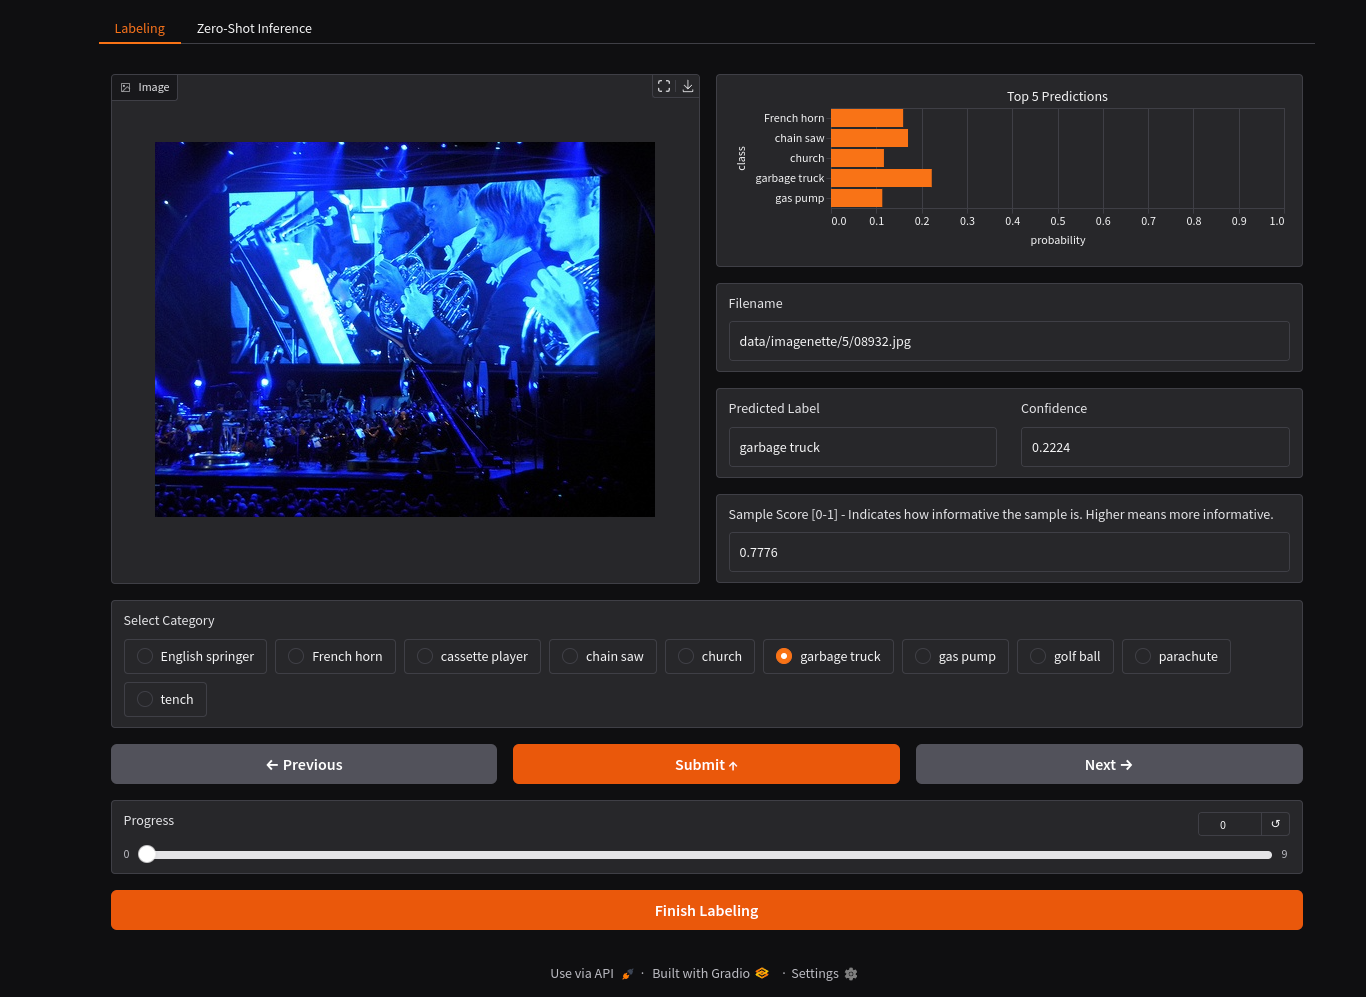

The Gradio interface will open up and you can label the samples. You could also see the confidence of the model for each sample to debug the model.

In [24]:
labeled_df = pd.read_parquet("imagenette/uncertain.parquet")

labeled_df


,filepath,label
0,data/imagenette/5/08932.jpg,French horn
1,data/imagenette/1/06511.jpg,English springer
2,data/imagenette/3/02368.jpg,chain saw
3,data/imagenette/7/05243.jpg,gas pump
4,data/imagenette/1/05709.jpg,English springer
5,data/imagenette/3/02178.jpg,chain saw
6,data/imagenette/0/01707.jpg,tench
7,data/imagenette/3/02432.jpg,chain saw
8,data/imagenette/6/08129.jpg,garbage truck
10,data/imagenette/9/03921.jpg,parachute


## Add to train set

Now that we have labeled the samples, we can add them to the train set.

In [25]:
al.add_to_train_set(labeled_df, output_filename="imagenette/active_labeled")

2025-01-25 00:20:54.404 | INFO     | active_vision.core:add_to_train_set:769 - Adding 10 samples to training set
2025-01-25 00:20:54.407 | INFO     | active_vision.core:add_to_train_set:778 - Saved training set to imagenette/active_labeled.parquet


## Repeat

We can repeat the process of predicting, sampling, labeling, and adding to the train set until we have a good model.